In [1]:
# Reading from full dataset (Method 1)
import time
import dask.dataframe as dd
import numpy as np
import pandas as pd
from datetime import datetime
dateparse = lambda x1, x2: datetime.strptime(x1+" "+x2, '%Y-%m-%d %H:%M')
df = dd.read_csv('./dataset/pm25/pm25_hourly_shard*.csv', dtype={'sample_measurement': 'float64', 'mdl': 'float64'}, parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)
df = df.compute()
df_copy = df.copy()

/opt/homebrew/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


In [16]:
# Reading from full dataset (Method 2)
# import pandas as pd
# import glob
# import functools
# df2 = pd.concat(map(functools.partial(pd.read_csv, sep='|', compression=None), glob.glob("dataset/pm25/PM2.5_Hourly_Shard_*.csv")))

In [1]:
# Reading from a subset of dataset
import numpy as np
import pandas as pd
from datetime import datetime

# Method 1 - TypeError
dateparse = lambda x1: datetime.strptime(x1, '%Y-%m-%d %H:%M')
df = pd.read_csv('./dataset/pm25_small_svr_cv_random.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)
df_copy = df.copy()

# Method 2 - ValueError, cannot convert string to float
# df = pd.read_csv('./dataset/pm25_small.csv')
# Method 3 - TypeError
# dateparse = lambda date, time: [datetime.strptime(x1[0]+" "+x1[1], '%Y-%m-%d %H:%M') for x1 in zip(date,time)]
# df = pd.read_csv('./dataset/pm25_small.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)

# Method 4 - TypeError
# def dateparse(d,t):
#     dt = d + " " + t
#     return pd.datetime.strptime(dt, '%Y-%m-%d %H:%M')
# df = pd.read_csv('./dataset/pm25_small.csv', parse_dates={'datetime_gmt': ['date_gmt', 'time_gmt']}, date_parser=dateparse)


In [2]:
# No Preprocessing
import datetime
y = df['sample_measurement']
y = y.to_numpy()
datetime_gmt_int = df_copy.apply(lambda x1: x1['datetime_gmt'].timestamp(), axis=1)
df['datetime_gmt'] = datetime_gmt_int
x = df.drop(['sample_measurement'], axis=1)
del df, df_copy, datetime_gmt_int
x_names = x.columns

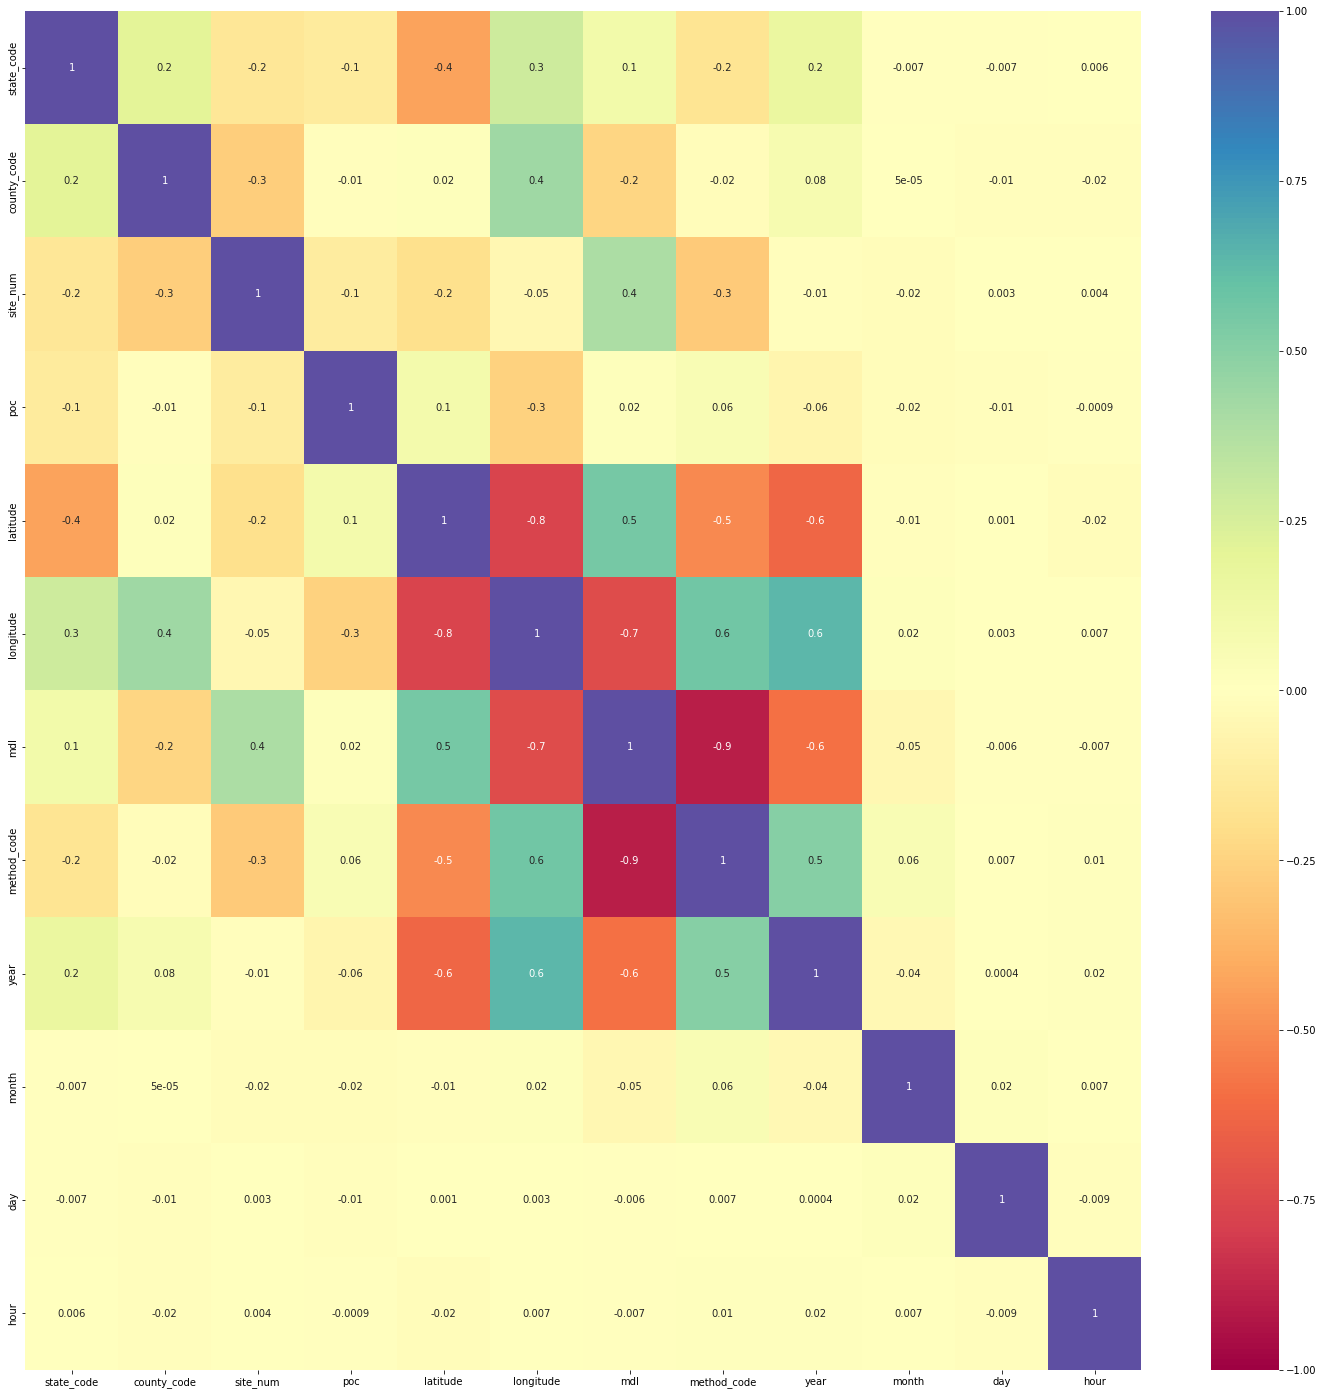

In [2]:
# Preprocessing
import datetime
y = df['sample_measurement']
y = y.to_numpy()
x = df.drop(['sample_measurement'], axis = 1)
del df, df_copy

# Feature extraction (see extract_features() in selFeat.py)
x['year'] = x['datetime_gmt'].dt.year
x['month'] = x['datetime_gmt'].dt.month
x['day'] = x['datetime_gmt'].dt.day
x['hour'] = x['datetime_gmt'].dt.hour
x = x.drop(columns = 'datetime_gmt')

# Feature selection
from matplotlib import pyplot as plt
import seaborn as sns

x_corr = x.corr()
fig = plt.figure(figsize=(25, 25))
fig.patch.set(facecolor = 'white')
sns.heatmap(x_corr, ax= plt.subplot(1, 1, 1), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='Spectral')
x = x.drop(columns = ['mdl', 'year'])
x_names = x.columns

In [3]:
# Train/Test split (Non-standardized and standardized)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.66, random_state=0)

# Feature standardization
from sklearn import preprocessing
stdScalarX = preprocessing.StandardScaler().fit(x_train)
x_train_std = stdScalarX.transform(x_train)
x_test_std = stdScalarX.transform(x_test)
x_train_std = pd.DataFrame(x_train_std, columns=x_names)
x_test_std = pd.DataFrame(x_test_std, columns=x_names)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
stdScalarY = preprocessing.StandardScaler().fit(y_train)
y_train_std = stdScalarY.transform(y_train)
y_test_std = stdScalarY.transform(y_test)

# Flattening arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_train_std = np.ravel(y_train_std)
y_test_std = np.ravel(y_test_std)

## Models

In [19]:
# Linear Regression (Non-Standardized)
from sklearn.linear_model import LinearRegression
reg1 = LinearRegression().fit(x_train, y_train)
yHat = reg1.predict(x_test)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')

MAE: 4.972924103384708
RMSE: 7.717659594229952
MAPE: 787783766159620.2
R^2: 0.02350011592727219



In [4]:
# Linear Regression with Ridge Regularization (Non-Standardized)
from sklearn.linear_model import RidgeCV
reg2 = RidgeCV(alphas = [ w], cv = 5, scoring = 'r2').fit(x_train, y_train)
yHat = reg2.predict(x_test)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.92214e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.93355e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.92198e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.92587e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarn

MAE: 4.935977649940148
RMSE: 7.680343283773633
MAPE: 796228140012538.0
R^2: 0.03292040114191064



In [5]:
# Support Vector Regression Non-CV (Non-Standardized)
from sklearn.svm import SVR
svr1 = SVR(kernel = 'rbf', epsilon = 0.1)
svr1.fit(x_train, y_train)
yHat = svr1.predict(x_test)

from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')

MAE: 5.217288649734779
RMSE: 10.091691435549217
MAPE: 478280604479647.2
R^2: -0.026766409004175706



In [ ]:
# Support Vector Regression CV (Non-Standardized)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr2 = GridSearchCV(SVR(), [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'epsilon': [0.1, 0.2, 0.3]}], cv=5, scoring='neg_mean_squared_error')
svr2.fit(x_train, y_train)
yHat = svr2.predict(x_test)

from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, yHat)}')
print(f'R^2: {metrics.r2_score(y_test, yHat)}\n')

# Data with standardization

In [21]:
# Linear Regression (Standardized)
from sklearn.linear_model import LinearRegression
reg3 = LinearRegression().fit(x_train_std, y_train_std)
yHat = reg3.predict(x_test_std)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test_std, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test_std, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test_std, yHat)}')
print(f'R^2: {metrics.r2_score(y_test_std, yHat)}\n')

MAE: 0.6361723805710953
RMSE: 0.9872987752129404
MAPE: 1.5761575667860643
R^2: 0.023500115927271747



In [5]:
# Linear Regression with Ridge Regularization (Standardized)
from sklearn.linear_model import RidgeCV
reg4 = RidgeCV(alphas = [0.1, 0.5, 1, 5, 10], cv = 5, scoring = 'r2').fit(x_train_std, y_train_std)
yHat = reg2.predict(x_test_std)
from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test_std, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test_std, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test_std, yHat)}')
print(f'R^2: {metrics.r2_score(y_test_std, yHat)}\n')

MAE: 28.56597550379305
RMSE: 28.587461719733483
MAPE: 233.1116560821697
R^2: -817.7026416493052



In [33]:
# Support Vector Regression Non-CV (Standardized)
from sklearn.svm import SVR
svr3 = SVR(kernel = 'rbf', epsilon = 0.3)
svr3.fit(x_train_std, y_train_std)
yHat = svr3.predict(x_test_std)

from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test_std, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test_std, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test_std, yHat)}')
print(f'R^2: {metrics.r2_score(y_test_std, yHat)}\n')

MAE: 0.4949880318780368
RMSE: 0.8076244252639341
MAPE: 1.583427588529226
R^2: 0.34290870141257457



In [38]:
# Support Vector Regression CV (Standardized)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
svr4 = GridSearchCV(SVR(), [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'epsilon': [0.1, 0.2, 0.3]}], cv=5, scoring='neg_mean_squared_error')
svr4.fit(x_train_std, y_train_std)
yHat = svr4.predict(x_test_std)

from sklearn import metrics
print(f'MAE: {metrics.mean_absolute_error(y_test_std, yHat)}')
print(f'RMSE: {metrics.mean_squared_error(y_test_std, yHat, squared=False)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test_std, yHat)}')
print(f'R^2: {metrics.r2_score(y_test_std, yHat)}\n')

MAE: 0.46844112091556195
RMSE: 0.8814261851768341
MAPE: 1.4702890376315647
R^2: 0.1757171977437877



In [28]:
# Cross Validation
from sklearn.model_selection import GridSearchCV
# GridSearchCV
# RepeatedKFold
# cross_validate
# cross_val_score